# COGS 108 - Final Project 

# Overview

This project uses a K-Nearest Neighbors and Radius Nearest Neighbors approach to see if geographical location and the number of previous locations could predict if a food establishment was higher risk for Wake County, North Carolina. Three models were built: one for spatial data, one for the previous number of locations, and one which combined the data. None of the models showed significant predictive power over a null model. It can be concluded that the geographic location of a food establishment and its past violations do not have enough predictive power on their own to be an accurate predictor for high risk establishments.

# Name & GitHub

- Name: Ryan Kim
- GitHub Username: rkim805

# Research Question

Is it possible to predict if a restaurant is high risk(At least two critical violations) with location being a primary predictor? Is it a better predictor than the previous number of violations a restaurant has made?

## Background and Prior Work

Restaurants are the greatest source of food-borne illness in the United States (1). The goal of public health inspection is to minimize the sources of food-borne illness. North Carolina Food Code indicates that critical violations are grounds for re-examination within the next 10 days, where permits are revoked if critical violations are not handled (2).

Critical health inspection violations are those which are more likely to contribute to food-borne illness. Examples of such violations are (2):
- Unapproved food sources 
- Poor employee hygiene
- Improper cooking temperature of foods
- Heavy vermin infestation

Non-critical health inspection violations are those that are unlikely to pose a risk to public health. Examples of such violations are (2): 
- Dirty floors/countertops
- Infrastructure in poor repair
- Light vermin infestation

This project seeks to predict whether or not a restauraunt is considered to be high risk from it's geographic location, using a machine learning approach. Similar types of food establishments may be more likely to have critical violations. In addition, there may be other ecological effects such as neighborhood income that may allow geospatial analysis to act as a predictor for critical violations.

"High risk" will be defined as a health inspection that has found at least two critical violations. This catagorization will be used throughout the project, and "higher risk" will be used interchangably with at least two critical violations.

An experimental machine learning approach is being developed in order to evaluate food safety by Harvard and Yale named FINDER, which seeks to re-evaluate the current standards by which food safety is measured. Predictions made by FINDER are "3.1 times as likely to be deemed unsafe during the inspection as restaurants identified by existing methods" (3). It uses location data as part of it's ability to track real-time food-borne illness. This implies that location will certainly help as a predictor for critical health inspection violations. This project seeks only to measure predictors based off of current standards -- these standards will likely drastically change over time as data driven methods are put into practice. 


References (include links):
- 1) http://www.foodprotection.org/files/food-protection-trends/MarApr-14-Burke-Manes.pdf
- 2) http://www.wakegov.com/food/healthinspections/rules/Documents/NC%20Food%20Code%20Manual%202009%20FINAL.pdf
- 3) https://www.nature.com/articles/s41746-018-0045-1

# Hypothesis


I believe that area will be a significant predictor(accuracy >85%) for violations with high levels of risk. Certain types of restaurants may have a higher chance of having critical violations, and the same types of restaurants are often clustered together. However, I believe that the previous number of critical and non-critical violations made will be able to predict high levels of risk more accurately(accuracy >90%).

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: https://github.com/rkim805/Projects/blob/master/inspections.csv
- Number of observations: 18466

Dataset containing information about various health inspections made in Wake County, including phone number, location, name of the health inspector/establishment, etc. Relevant data used are geospatial coordinates for each food establishment, whether an inspection was deemed critical(>1 critical violations made), and the number of previous critical/non-critical violations.

- Dataset Name: NC_ZIPCODES.geojson
- Link to the dataset: https://data-ral.opendata.arcgis.com/datasets/Wake::zip-codes
- Number of observations: 66

GeoJSON dataset used containing data to draw boundaries and show data distributions geographically for Wake County.

The inpsections dataset will be combined with the GeoJSON data in order visualize geographic distributions of our data, in order to observe spatial relationships and distributions.

# Setup

In [374]:
!pip install --user geopandas
!pip install --user shapely
!pip install --user descartes

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (13, 7)

#used to create legend for geographical distribution
import matplotlib.patches as mpatches

import numpy as np
import pandas as pd
import numpy as np

import sklearn.neighbors as skn
import sklearn.metrics as skm

import warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import shapely.geometry as shp

# Data Cleaning

### Checking for Invalid Location Data

The dataframe is loaded from the linked .csv data. The data is well formatted for a GeoDataFrame. We check to see if there are any outstanding values for our geolocation data.

In [541]:
df_inspec = pd.read_csv('data/inspections.csv')
NC = gpd.read_file('data/NC_ZIPCODES.geojson')

NullValues = df_inspec[df_inspec['x'] == np.nan]
NullValues.size

0

In [542]:
NullValues = df_inspec[df_inspec['y'] == np.nan]
NullValues.size

0

No null data -- we then check to see if there are any data with coordinates that would not belong to Wake County instead, but we have none. The GeoJSON file should be clean and accurately map Wake County.

In [543]:
XBoundary = df_inspec[df_inspec['x'] > -78]
XBoundary.size

0

In [544]:
XBoundary = df_inspec[df_inspec['x'] < -79]
XBoundary.size

0

In [545]:
YBoundary = df_inspec[df_inspec['y'] < 35]
YBoundary.size

0

In [546]:
YBoundary = df_inspec[df_inspec['y'] > 36.5]
YBoundary.size

0

### Data Selection and Formatting
Relevant variables from the data are selected -- including previous inspection violations and whether or not the inspection considered a restaurant high risk.

The original "critical" column in the dataset references inspections with at least one critical violation. For the purposes of this project, we defined "high risk" as having at least two critical health violations, so we change the critical column to encode '1' as having at least two critical violations, and '0' as having 1 or less critical violations,

The x and y coordinates are transformed into a Shapely object. We transform our df_inspec DataFrame into a GeoDataFrame named df. This is done to be able to view in order to perform geospatial analysis later on.

We then load in a .geojson for Wake County in order to use it as a base plot for our data later.


After data selection, we check to see if any of our relevant data has any null values.

In [547]:
df = df_inspec[["x", "y", "num_critical_previous", 
                "num_non_critical_previous", "critical", "zip", 
                'num_critical']]

#transform critical such that '1' means there are at least 2
#critical violations in that inspection
df['critical'] = (df['num_critical'] > 1).astype(int)

#create polygon used for later mapping
shapeObj = gpd.points_from_xy(df.x, df.y)
df = gpd.GeoDataFrame(df)
df['geometry'] = shapeObj

df = df.drop(columns=["x", "y", 'num_critical'])
df.isna()
df

,num_critical_previous,num_non_critical_previous,critical,zip,geometry
0,NaN,NaN,1,27610,POINT (-78.58796 35.78391)
1,NaN,NaN,0,27610,POINT (-78.54967 35.79199)
2,NaN,NaN,1,27610,POINT (-78.54796 35.72313)
3,NaN,NaN,1,27513,POINT (-78.81573 35.79925)
4,NaN,NaN,1,27597,POINT (-78.29635 35.83129)
...,...,...,...,...,...
18461,1.0,4.0,1,27616,POINT (-78.57159 35.86546)
18462,2.0,5.0,1,27513,POINT (-78.81014 35.79244)
18463,0.0,2.0,1,27519,POINT (-78.89958 35.85913)
18464,0.0,3.0,0,27603,POINT (-78.69734 35.66520)


We can see we have some null values. Further analysis shows that null values are only in the num_critical previous and num_non_critical_previous. These represent first-time inspections of a food establishment. Our analysis will not capture predictions for these first-time inspections. 

This should not affect our overall analysis. There are already standards on how quickly new restaurants will be inspected -- we are interested in analyzing inspections of already established restaurants.

We check to see if there are any null values after dropping any first-time inspections, and see there are none. The data is now suitably clean enough to be merged with our GeoJSON data.

In [548]:
df = df[df['num_critical_previous'].notna()]
df.isnull().values.any()

False

### Associating Zip Code Related Information with our GeoJSON Data:
Viewing zipcodes of our data thus far to see if there are any missing/different values:

In [549]:
df['zip'].unique()

array([27513, 27502, 27511, 27519, 27587, 27610, 27591, 27539, 27597,
       27603, 27612, 27616, 27540, 27526, 27615, 27545, 27518, 27529,
       27609, 27604, 27607, 27614, 27606, 27571, 27523, 27617, 27608,
       27605, 27601, 27613, 27560, 27602, 27520, 27562, 27592, 27695,
       27573, 27512, 27628, 27624, 27652, 27709, 27595, 27650, 27596,
       27501, 27579, 28145, 27522, 28587])

In [550]:
NC['ZIPNUM'].unique()

array([27601., 27713., 27604., 27587., 27703., 27571., 27545., 27603.,
       27522., 27596., 27615., 27616., 27612., 27591., 27609., 27605.,
       27502., 27529., 27608., 27610., 27520., 27501., 27613., 27614.,
       27518., 27523., 27617., 27597., 27511., 27519., 27513., 27607.,
       27606., 27560., 27539., 27526.,    nan, 27562., 27592., 27540.])

Zipcodes both files are slightly different. However, we will be using zip code related information to visualize geospacially related distributions. While we will not be able to show all food establishments on our figure, we will be able to show the distributions throughout the areas that our NC dataset has. We primarily want to see geospatial autocorrelation with our data. The missing zip codes should not prevent our ability to see autocorrelation.

Our base map(NC) will be joined with the other DataFrame in order to help us represent this distribution.

In [582]:
#Rename NC in order to merge with other datasets later.
NC = NC.rename(columns={'ZIPNUM': 'zip'})

We then calculate the percentage of food establishments who are high risk:

In [552]:
#Count the number of inspections made for each zip code
dfNumViolationsByZip = df.groupby(['zip']).count()['critical']
#Count the number of high risk inspections found
dfNumCriticalByZip = df.groupby(['zip']).sum()['critical']
dfCriticalRate = dfNumCriticalByZip/dfNumViolationsByZip

#reset index and rename for later merge
dfCriticalRate = dfCriticalRate.reset_index()
dfCriticalRate = dfCriticalRate.rename(columns={'critical': 'CriticalRate'})

We then merge two sources of data with our GeoJSON data: the perentage of high risk inspections made, number of percentage of families below the poverty threshold.

In [553]:
#Rename NC in order to merge with other datasets later.
NC = NC.rename(columns={'ZIPNUM': 'zip'})
NC = NC.merge(dfCriticalRate, on='zip')

# Data Analysis & Results

### EDA
The data consists of: 
- num_critical_previous: Number of critical violations in the previous inspection
- num_non_critical_previous: Number of non-critical violations made in the current inspection
- critical: A catagorical value with a binary representation, where '1' represents at least two critical violations in the current inspection(high risk). '0' represents no critical violations.

Geometry is used for geospatial analysis -- the points represent the longitude/latitude of the restaurant's location.

In [389]:
df

,num_critical_previous,num_non_critical_previous,critical,zip,geometry
12960,0.0,3.0,0,27615,POINT (-78.60101 35.89311)
2358,2.0,4.0,1,27591,POINT (-78.41589 35.79772)
17498,0.0,4.0,0,27606,POINT (-78.73934 35.76696)
15125,2.0,5.0,0,27519,POINT (-78.90108 35.82060)
12862,0.0,1.0,1,27526,POINT (-78.77463 35.59446)
...,...,...,...,...,...
3696,2.0,2.0,0,27606,POINT (-78.73391 35.74400)
4427,0.0,5.0,1,27511,POINT (-78.78269 35.77099)
16788,8.0,9.0,1,27513,POINT (-78.76458 35.82990)
4884,5.0,8.0,1,27603,POINT (-78.64757 35.78780)


Below are the plots and statistical data from the DataFrame.
We can see that both distributions for the previous number of violations are fairly skewed(restuarants with a higher number of violations are much less common). Normalizing the data with the Yeo-Johnson transformation does not create normal distributions within the data, thus a non-parametric approach is taken in order to analyze the data.

These plots follow a similarly skewed distrbution. There are restaurants with an outstanding number of critical/non-critical violations(>20 for the former, >30 for the latter), that are many standard deviations away from the mean for each plot. 

Howver, they are within the expected bounds of an especially poor health inspection, although these are rare, and do not appear to be input errors within the data. Thus, we will keep these values in our training/testing data. Removing the data would involve removing valid data, thus possibly removing information about data on the higher end of the distribution.

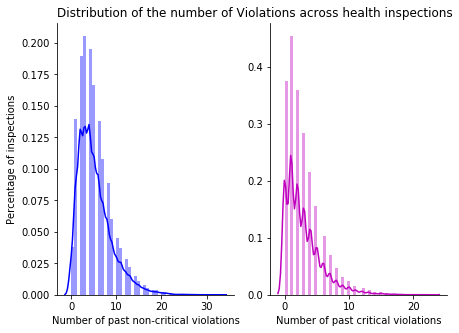

In [554]:
fig, (plot1, plot2) = plt.subplots(ncols=2, sharey=True)

plt.subplot(1, 2, 1)
plot1 = sns.distplot(df[('num_non_critical_previous')], color='blue')
plt.subplot(1, 2, 2)
plot2 = sns.distplot(df['num_critical_previous'], color='m')
plot1.set_ylabel('Percentage of inspections')
plot2.set_xlabel('Number of past critical violations')
plot1.set_xlabel('Number of past non-critical violations')


plot1.set_title('Distribution of the number of Violations across health inspections', loc='left')
sns.despine()

In [555]:
df.describe()

,num_critical_previous,num_non_critical_previous,critical,zip
count,15421.000000,15421.000000,15421.000000,15421.000000
mean,2.922962,5.257052,0.577589,27577.590883
std,2.831160,3.738389,0.493959,43.521590
min,0.000000,0.000000,0.000000,27501.000000
25%,1.000000,3.000000,0.000000,27529.000000
50%,2.000000,4.000000,1.000000,27603.000000
75%,4.000000,7.000000,1.000000,27610.000000
max,23.000000,33.000000,1.000000,28587.000000


The figure below plots the number of inspections that had found no critical violations vs. the number of inspections that found at least 2 critical violations.

We can see from the figure below that of food establishmennts were higher risk --  a cause for concern considering critical violations are considered severe enough to cause a license to be revoked if not fixed quickly enough.

However, the data does not show any relavant information from a geospatial point of view.

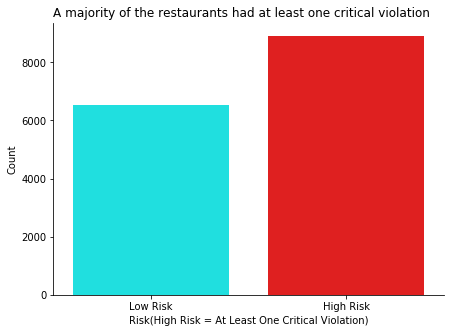

In [556]:
ax = sns.countplot(x='critical', data=df, palette={1: "red", 0 : "cyan"})
ax.set_title('A majority of the restaurants had at least one critical violation', loc='left')
ax.set_ylabel('Count')
ax.set_xlabel('Risk(High Risk = At Least One Critical Violation)')

ax.set_xticklabels(('Low Risk', 'High Risk'));
sns.despine()

plt.rcParams['figure.figsize'] = (7, 5)



The figure below plots all of the inspections on a map of Wake County.

From the figure, it is difficult to tell if any boundaries are spatially auto-correlated. We can see that the number of inspections done in our dataset is much greater towards the center of Wake County. The capital of North Carolina, Raleigh, is in the center; some of the larger cities are around the center, so naturally, there are more inspections within those cities.

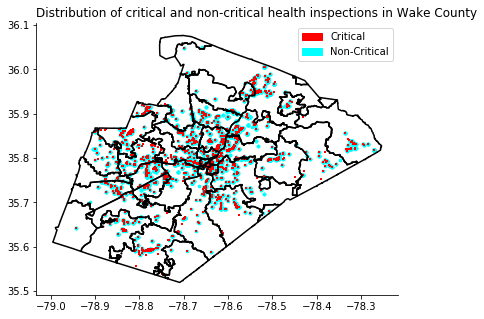

In [557]:
base = NC.boundary.plot(edgecolor='black')

df_critical = df[df['critical'] == 1]
df_non_critical = df[df['critical'] == 0]

df_non_critical.plot(ax=base, marker='o', color='cyan', markersize=7)
df_critical.plot(ax=base, marker='+', color='red', markersize=7)

red_patch = mpatches.Patch(color='red', label='Critical')
blue_patch = mpatches.Patch(color='cyan', label='Non-Critical')
plt.legend(handles=[red_patch, blue_patch])

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
base.set_title("Distribution of critical and non-critical health inspections in Wake County", loc='left')
sns.despine()

It was difficult to find any underlying patterns in the figure above -- so a choropleth map seems fitting in order to help find any distributions throughout the regions of North Carolina. 

The below figure is a choropleth map that shows the percentage of restaurants that are higher risk.

It is important to note that although there appears to be an area with 100% high risk inspection areas, they are areas in which our data had low numbers of inspections, as seen in the figure above.

It is still difficult to view any effects of spatial autocorrelation in this choropleth. In order to better visualize effects of spatial autocorrelation, we will look at the extremes of our data.

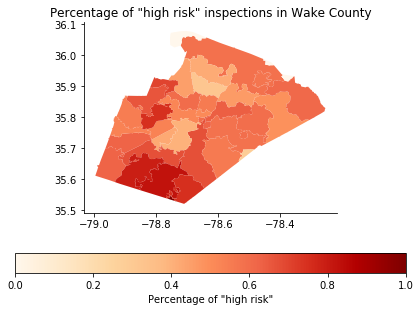

In [584]:
clmap = NC.plot(column='CriticalRate', 
                cmap='OrRd', 
                legend=True,
                legend_kwds={'label': 'Percentage of "high risk"',
                             'orientation': 'horizontal'})
clmap.set_title('Percentage of "high risk" inspections in Wake County')
sns.despine()

We will split our data based off of its median. Any value greater than the median will be considered to be of "higher" risk amongst our distribution. Any value less than the median will be considered to be of "lower" risk amongst our distribution.

In [559]:
y = NC['CriticalRate']
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
NC['yb'] = yb

After splitting our distribution using one hot encoding, we are able to see clear geospatial correlation. We still have the areas with low amounts of inspections, but even within the areas with large amounts of inspections, there is clear autospatial correlation, a good sign that geospatial data can help to predict whether or not a restaurant has at least two critical violations.

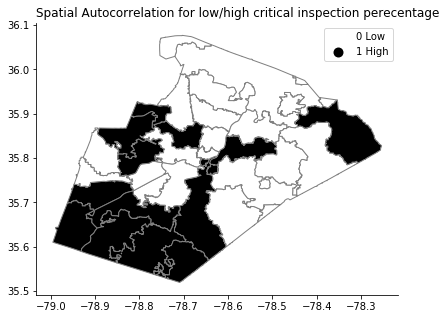

In [560]:
binMap = NC.plot(column='yb', cmap='binary', legend=True, edgecolor='grey')
binMap.set_title('Spatial Autocorrelation for low/high critical inspection perecentage', loc='left')
sns.despine()

### Nearest Neighbors Classification
We will use a K-Nearest Neighbors Classifier as our predictor. We are attempting to analyze geospatial data, so an approach that is able to take spatial data into account is mandatory. In addition, the underlying distributions for the number of previous critical/non-critical violations is highly skewed. Attempting to transform the data has lead to distributions that were still not normal, so a non-parametric approach needs to be used.

We will train three classifiers. One model using the inspection violations as tge training data, one model using geographical distance, and one model using both. Relevant data is taken from the model and is specified as either a predictor(x) or outcome(y) variable.

In [561]:
#Select relevant data from our model
xLabels = ['num_critical_previous', 'num_critical_previous']
X = df[xLabels].values
X = X.astype(float)
y = df['critical'].values

We will also need the spatial coordinates for each inspection:

In [562]:
coordinates = np.vstack(df.geometry.apply(lambda p: np.hstack(p.xy)).values)

We will now randomize our data and split it into training/testing data, taking an 80/20 split:

In [571]:
randomized = np.random.permutation(len(y))
num =  int(0.8*len(randomized))
train, test = randomized[:num],randomized[num:]

Here is where we will train our three models: one based off spatial data alone, one based off of prior violations, and one based off of both:

In [572]:
#spatial predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=3)
spatial = KNNC.fit(coordinates[train,:], y[train])

#previous violation predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=3)
prev = KNNC.fit(X[train,:], y[train])

#combined
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=3)
both = KNNC.fit(np.hstack((coordinates[train,:], 
                           X[train,:])), y[train])

Here, we have our models make our predictions on the training data using our three models.

In [573]:
sp_ypred_train = spatial.predict(coordinates[train,:])
prev_ypred_train = prev.predict(X[train,:])
both_ypred_train = both.predict(np.hstack((coordinates[train,:], 
                                           X[train,:])))

(skm.accuracy_score(sp_ypred_train, y[train]),
skm.accuracy_score(prev_ypred_train, y[train]),
skm.accuracy_score(both_ypred_train, y[train]))

(0.7034695201037614, 0.6325389105058365, 0.8465466926070039)

Here, we do the same tests, increasing the number of neighbors to see what will give the highest accuracy in order to tune our model:

In [574]:
#spatial predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=10)
spatial2 = KNNC.fit(coordinates[train,:], y[train])

#previous violation predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=10)
prev2 = KNNC.fit(X[train,:], y[train])

#combined
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=10)
both2 = KNNC.fit(np.hstack((coordinates[train,:], 
                           X[train,:])), y[train])

sp_ypred_train2 = spatial2.predict(coordinates[train,:])
prev_ypred_train2 = prev2.predict(X[train,:])
both_ypred_train2 = both2.predict(np.hstack((coordinates[train,:], 
                                           X[train,:])))

(skm.accuracy_score(sp_ypred_train2, y[train]),
skm.accuracy_score(prev_ypred_train2, y[train]),
skm.accuracy_score(both_ypred_train2, y[train]))

(0.7306258106355382, 0.6813391699092088, 0.852707522697795)

In [575]:
#spatial predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=40)
spatial3 = KNNC.fit(coordinates[train,:], y[train])

#previous violation predictor
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=40)
prev3 = KNNC.fit(X[train,:], y[train])

#combined
KNNC = skn.KNeighborsClassifier(weights='distance', n_neighbors=40)
both3 = KNNC.fit(np.hstack((coordinates[train,:], 
                           X[train,:])), y[train])

sp_ypred_train3 = spatial3.predict(coordinates[train,:])
prev_ypred_train3 = prev3.predict(X[train,:])
both_ypred_train3 = both3.predict(np.hstack((coordinates[train,:], 
                                           X[train,:])))

(skm.accuracy_score(sp_ypred_train3, y[train]),
skm.accuracy_score(prev_ypred_train3, y[train]),
skm.accuracy_score(both_ypred_train3, y[train]))

(0.7374351491569391, 0.6813391699092088, 0.853112840466926)

Increasing the number of neighbors does not appear to greatly affect our predictive power. Our individual factors appear to guess relatively poorly.

Our spatial model has an accuracy of 73% at max, and the past number of violations model has an accuracy of 65%. Our model that combines both has an accuracy of 85%.

 We choose the 3rd model as the one to run against the test data:

In [576]:
sp_ypred = spatial3.predict(coordinates[test,:])
prev_ypred = prev3.predict(X[test,:])
both_ypred = both3.predict(np.hstack((coordinates[test,:], 
                                      X[test,:])))

(skm.accuracy_score(sp_ypred, y[test]),
skm.accuracy_score(prev_ypred, y[test]),
skm.accuracy_score(both_ypred, y[test]))

(0.6609400324149108, 0.700162074554295, 0.6612641815235009)

All three models end up being able to predict on the test data with an accuracy of 66-70% -- not great.

Let us see what a model that simply always predicts 'high risk' will produce, as a null accuracy test. This is equivalent to the percentage of ones found in the data. We can find the number of one's in our outcome variable by simply calculating the mean, since it is only composed of ones and zeros:

In [578]:
nullTestSeries = pd.Series(y[test])
nullTestSeries.value_counts()
nullTestSeries.mean()

0.5837925445705024

A simple model that predicts the more frequent value is able to predict with 58% accuracy. While our models show slightly improved prediction over this null model, they can hardly be called strong predictors.

Perhaps the areas with low levels of inspections are skewing our data. We can instead use a radius neighbors classifier approach to attempt to deal with these areas:

In [579]:
#spatial predictor
RNC = skn.RadiusNeighborsClassifier(weights='distance', radius=1.0)
spatialR = RNC.fit(coordinates[train,:], y[train])

#previous violation predictor
RNC = skn.RadiusNeighborsClassifier(weights='distance', radius=1.0)
prevR = RNC.fit(X[train,:], y[train])

#combined
RNC = skn.RadiusNeighborsClassifier(weights='distance', radius=1.0)
bothR = RNC.fit(np.hstack((coordinates[train,:], 
                           X[train,:])), y[train])

sp_ypred_trainR = spatialR.predict(coordinates[train,:])
prev_ypred_trainR = prevR.predict(X[train,:])
both_ypred_trainR = bothR.predict(np.hstack((coordinates[train,:], 
                                           X[train,:])))

(skm.accuracy_score(sp_ypred_trainR, y[train]),
skm.accuracy_score(prev_ypred_trainR, y[train]),
skm.accuracy_score(both_ypred_trainR, y[train]))

(0.7374351491569391, 0.6813391699092088, 0.853112840466926)

We appear to get similar prediction values from our training data. Using our test data:

In [581]:
sp_ypred_R = spatialR.predict(coordinates[test,:])
prev_ypred_R = prevR.predict(X[test,:])
both_ypred_R = bothR.predict(np.hstack((coordinates[test,:], 
                                           X[test,:])))

(skm.accuracy_score(sp_ypred_R, y[test]),
skm.accuracy_score(prev_ypred_R, y[test]),
skm.accuracy_score(both_ypred_R, y[test]))

(0.6606158833063209, 0.700162074554295, 0.6586709886547812)

We again appear to have poor predictive power, even with radius neighbors classifiers. It appears that geographic location is a poor predictor for higher risk inspections. It is possible that adding additional features to our model can create a model that is accurately able to predict higher risk inspections -- but it is clear that location does not achieve significant predictive power by itself.

It is also clear that it does not offer any significant power above the previous number of violations, nor does combining the two give more predictive accuracy.

# Ethics & Privacy

This data is made publicly available for use by the Wake County Health Department. This data is inherently publicly available, so ties to certain restaraunts or health inspectors will not leak private information, and it is available for use to everybody. Data was selected to not show information such as an establishment's phone number. Common aspects of data security such as encryption are therefore unneeded to protect the data.

There are possible inhererent biases in the dataset that could be present due to biases in the health inspection process(i.e. against certain types of ethnic restaurants being more strictly graded). One of particular concern is that of socioeconomic status. It is possible that health inspectors are harsher with food establishments in areas with high levels of poverty or low levels of income.  Our findings have not found that spatial relations can predict higher risk restaurants, so possible ecological sources of bias can not be interpretted from the model. Thus, there should not be any findings that can be used against lower income neighborhoods in this project. 

The data is also biased in that many of the inspections found are more likely to be concentrated in the middle of Wake County, where Raleigh is located. The area is more populated, so the machine learning model may favor ecological trends that are found in more populated areas. However, trends found in less populated areas were similar to those found in more populated areas.

Because the model shows little predictive power with regards to finding higher risk restaurants, the model shouldn't have the capability to be misinterpreted or abused to extract inequitable information against certain groups.

# Conclusion & Discussion

This project attempted to see if it possible to predict if a restaurant is high risk(At least two critical violations) based off of its location by using supervised machine learning. It also attempted to see if geographical location was a better predictor than the previous number of violations a restaurant has made. The hypothesis was that the location would be a significant predictor(>85% accuracy), but less than accurate than the number of previous violations.

Health inspection data from Wake County was used. Relevant data included the number of previous critical/non-critical violations, and a binary variable for whether or not the observation had at least 2 current critical violations. The data showed autospatial correlation in intial exploratory data analysis. The outcome variable was catagorical -- so a Nearest Neighbors/Radius Neighbors approach was taken in order to predict the catagorical outcome.

Three models were created for each approach -- a model for only the spatial data, a model based off the previous violation number, and a model using both. Both machine learning approaches failed to show significant amounts of predictive power for all 3 models over a null model that simply predicted high risk every time. Tuning was done for the K nearest neighbors approach, but it did not affect the predictive power noticably. Thus, it was concluded that, while geographic location might be able to be used as an additional feature in a machine learning approach, it does not have enough predictive power on its own, and it was slightly worse at predictions than the previous number of violations model. This project helps to show the relatively weak predictive power of geographical location for higher risk restaurants -- future machine learning projects should be able to use it as an additional feature, but not as a primary predictor.